# Installation


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

# Getting Stock Data

In [ ]:
tsla = yf.Ticker('TSLA')
nflx = yf.Ticker('NFLX')
nvda = yf.Ticker('NVDA')
amd = yf.Ticker('AMD')
msft = yf.Ticker('MSFT')
tbill = yf.Ticker('^TNX')
gspc = yf.Ticker('^GSPC')
portfolio = pd.DataFrame()
Tbill = pd.DataFrame()
market = pd.DataFrame()
portfolio["tsla"] = tsla.history(period = '253d')["Close"]
portfolio["nflx"] = nflx.history(period = "253d")["Close"]
portfolio["nvda"] = nvda.history(period = "253d")["Close"]
portfolio["amd"] = amd.history(period = "253d")["Close"]
portfolio["msft"] = msft.history(period = "253d")["Close"]
Tbill['tbill'] = tbill.history(period = '253d')["Close"]
market['gspc'] = gspc.history(period = '253d')["Close"]

# Risk Free Interest Rates

In [ ]:
returns = portfolio.pct_change()
tbill_rate = Tbill.pct_change()
market_returns = market.pct_change()
returns['tsla'] -= tbill_rate["tbill"]
returns['nflx'] -= tbill_rate["tbill"]
returns['nvda'] -= tbill_rate["tbill"]
returns['amd'] -= tbill_rate["tbill"]
returns['msft'] -= tbill_rate["tbill"]
excess_market_return = pd.DataFrame()
excess_market_return['gspc'] = market_returns['gspc'] - tbill_rate["tbill"]

# Price of Risk

\begin{align}
  A = \frac{E(r_m) - r_f}{σ_m^2}
\end{align}

In [ ]:
average_excess_returns = excess_market_return.mean()
variance = np.var(market_returns)
a = average_excess_returns / variance
A = a.iloc[0]
A

-26.59466469089912

 # Variance Covariance Matrix

In [ ]:
S = returns.cov()
S

,tsla,nflx,nvda,amd,msft
tsla,0.002423,0.001844,0.001968,0.001844,0.001391
nflx,0.001844,0.003090,0.001910,0.001738,0.001396
nvda,0.001968,0.001910,0.002452,0.002183,0.001567
amd,0.001844,0.001738,0.002183,0.002270,0.001443
msft,0.001391,0.001396,0.001567,0.001443,0.001390


# Market Weights

In [ ]:
market_cap = {'tsla' : tsla.info['marketCap'], 'nflx' : nflx.info['marketCap'], 'nvda' : nvda.info['marketCap'], 'amd' : amd.info['marketCap'], 'msft' : msft.info['marketCap']}
sum_weights = market_cap['tsla'] + market_cap['nflx'] + market_cap['nvda'] + market_cap['amd'] + market_cap['msft']
w = np.empty(5)
w[0] = market_cap['tsla'] / sum_weights
w[1] = market_cap['nflx'] / sum_weights
w[2] = market_cap['nvda'] / sum_weights
w[3] = market_cap['amd'] / sum_weights
w[4] = market_cap['msft'] / sum_weights

# Implied Equilibrium Excess Return

\begin{align}
  π = ASw
\end{align}

In [ ]:
pi = A * np.dot(S, w)
pi

array([-0.04633283, -0.04383124, -0.04797632, -0.04435188, -0.03758937])

# Views and Link Matrix (Order: tsla, nflx, nvda, amd, msft)

In [ ]:
Q = np.array([0.005, 0.01, 0.005])
P = np.array([[0, 0, 0, -1, 1], [0, -1, 1, 0, 0], [-1, 1, 0, 0, 0]])

# Uncertainty About Views

\begin{align}
  \Omega = τPSP^T  
\end{align}

where $\tau = 1$

In [ ]:
omega = 1 * np.dot(np.dot(P, S), np.transpose(P))
omega

array([[ 0.00077464, -0.00027438,  0.00011053],
       [-0.00027438,  0.00172115, -0.00130435],
       [ 0.00011053, -0.00130435,  0.00182492]])

# Solving first term of Black Litterman Formula

\begin{align}
  [(τS)^{-1} + P^TΩ^{-1}P]^{-1}
\end{align}

In [ ]:
first_term = np.linalg.inv(np.linalg.inv(S) + np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P))
first_term

array([[0.0021118 , 0.00182239, 0.00188472, 0.00164694, 0.00142077],
       [0.00182239, 0.00244543, 0.00185559, 0.00159419, 0.00142329],
       [0.00188472, 0.00185559, 0.00212632, 0.00181684, 0.00150875],
       [0.00164694, 0.00159419, 0.00181684, 0.00181081, 0.00139709],
       [0.00142077, 0.00142329, 0.00150875, 0.00139709, 0.00137069]])

# Solving second term of Black Litterman Formula

\begin{align}
  [(τS)^{-1}π + P^TΩ^{-1}Q]
\end{align}

In [ ]:
second_term = np.dot(np.linalg.inv(S), pi) + np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)
second_term

array([-22.73514932,  -4.76385737,  16.83493044, -12.11205798,
        -3.81853047])

# Expected Returns Based on Black Litterman Model

\begin{align}
E(r) - r_f = [(τS)^{-1} + P^TΩ^{-1}P]^{-1}[(τS)^{-1}π + P^TΩ^{-1}Q]
\end{align}

In [ ]:
expected_returns = np.dot(first_term, second_term)
expected_returns

array([-0.05033775, -0.04658696, -0.0436595 , -0.04171892, -0.03583767])

# Black Litterman vs Historical Average

In [ ]:
print("historical average: ", returns.mean().to_numpy())
print("black litterman: ", expected_returns)

historical average:  [-0.00622514 -0.00682578 -0.00736429 -0.00787661 -0.00620506]
black litterman:  [-0.05033775 -0.04658696 -0.0436595  -0.04171892 -0.03583767]


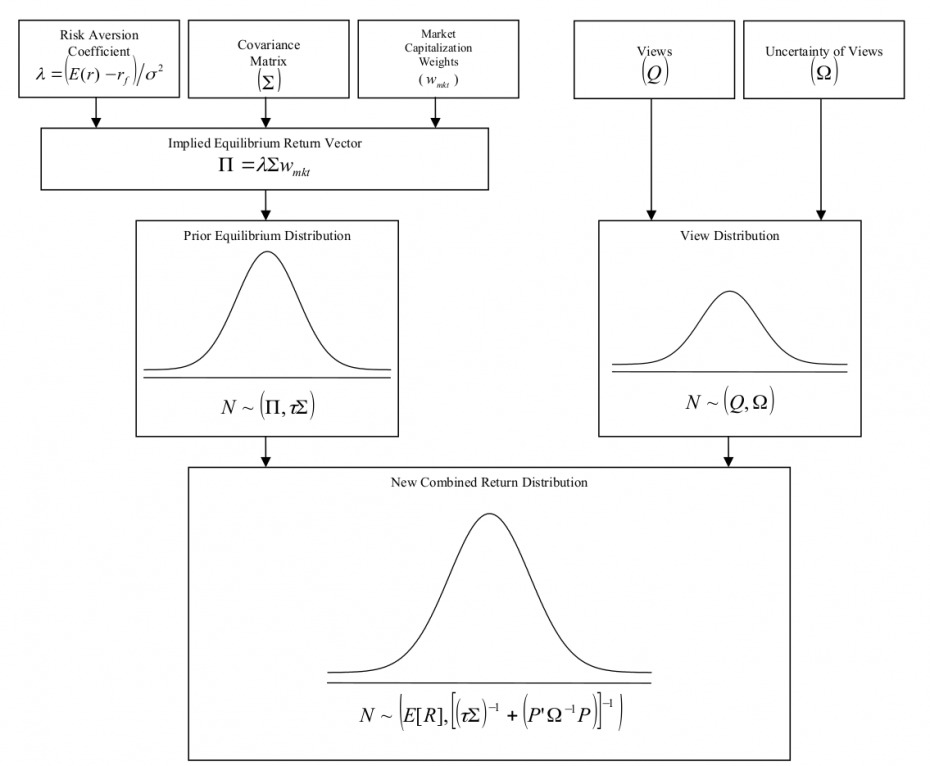

# Reference

https://www.youtube.com/watch?v=I3MKp2dL4Hk&t=2s&ab_channel=FriendlyFinancewithChandraS.Bhatnagar

https://people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf